<a href="https://colab.research.google.com/github/totminaekaterina/RUSSE-2022-Detoxification/blob/main/evaluation_with_metricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
use_cuda = False

In [2]:
!pip install rouge

In [3]:
!pip install --upgrade transformers==4.6.0

     |████████████████████████████████| 2.3 MB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 43.4 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 


In [4]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
from tqdm.auto import tqdm, trange
from nltk.translate.chrf_score import corpus_chrf

In [5]:
import json
from collections import Counter
import re
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
import random

In [6]:
MAX_LENGTH = 200


def get_word_tokens(text):
    tokens = re.sub(r"[^\w\s]", "", text).split()
    tokens = [t.lower() for t in tokens]
    return tokens


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def get_similarities(model, tokenizer, input_texts, output_texts):
    encoded_input = tokenizer(input_texts, padding=True, truncation=True,
                              max_length=MAX_LENGTH, return_tensors="pt").to(model.device)
    encoded_output = tokenizer(output_texts, padding=True, truncation=True,
                              max_length=MAX_LENGTH, return_tensors="pt").to(model.device)

    with torch.no_grad():
        model_emb_input = model(**encoded_input)
        model_emb_output = model(**encoded_output)

    input_embeddings = mean_pooling(model_emb_input, encoded_input["attention_mask"]).cpu()
    output_embeddings = mean_pooling(model_emb_output, encoded_output["attention_mask"]).cpu()
    similarity = cosine_similarity(input_embeddings, output_embeddings)
    return similarity

def get_rougel(input_text, output_text):
  rouge = Rouge()
  scores = []
  try:
      score = rouge.get_scores(input_text, output_text)[0]
      score = score["rouge-l"]["f"]
  except ValueError:  
      score = 0.0
  return score


def set_random_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [7]:
def prepare_target_label(model, target_label):
    if target_label in model.config.id2label:
        pass
    elif target_label in model.config.label2id:
        target_label = model.config.label2id.get(target_label)
    elif target_label.isnumeric() and int(target_label) in model.config.id2label:
        target_label = int(target_label)
    else:
        raise ValueError(f'target_label "{target_label}" is not in model labels or ids: {model.config.id2label}.')
    return target_label


def classify_texts(model, tokenizer, texts, second_texts=None, target_label=None, batch_size=32, verbose=False):
    target_label = prepare_target_label(model, target_label)
    res = []
    if verbose:
        tq = trange
    else:
        tq = range
    for i in tq(0, len(texts), batch_size):
        inputs = [texts[i:i+batch_size]]
        if second_texts is not None:
            inputs.append(second_texts[i:i+batch_size])
        inputs = tokenizer(*inputs, return_tensors='pt', padding=True, truncation=True, max_length=512).to(model.device)
        with torch.no_grad():
            preds = torch.softmax(model(**inputs).logits, -1)[:, target_label].cpu().numpy()
        res.append(preds)
    return np.concatenate(res)


def evaluate_style(
    model,
    tokenizer,
    texts,
    target_label=1,  # 1 is toxic, 0 is neutral
    batch_size=32, 
    verbose=False
):
    target_label = prepare_target_label(model, target_label)
    scores = classify_texts(
        model,
        tokenizer,
        texts, 
        batch_size=batch_size, verbose=verbose, target_label=target_label
    )
    return rotation_calibration(scores, 0.90)


def evaluate_meaning(
    model,
    tokenizer,
    original_texts, 
    rewritten_texts,
    target_label='entailment', 
    bidirectional=True, 
    batch_size=32, 
    verbose=False, 
    aggregation='prod'
):
    target_label = prepare_target_label(model, target_label)
    scores = classify_texts(
        model, tokenizer,
        original_texts, rewritten_texts, 
        batch_size=batch_size, verbose=verbose, target_label=target_label
    )
    if bidirectional:
        reverse_scores = classify_texts(
            model, tokenizer,
            rewritten_texts, original_texts,
            batch_size=batch_size, verbose=verbose, target_label=target_label
        )
        if aggregation == 'prod':
            scores = reverse_scores * scores
        elif aggregation == 'mean':
            scores = (reverse_scores + scores) / 2
        elif aggregation == 'f1':
            scores = 2 * reverse_scores * scores / (reverse_scores + scores)
        else:
            raise ValueError('aggregation should be one of "mean", "prod", "f1"')
    return scores


def encode_cls(texts, model, tokenizer, batch_size=32, verbose=False):
    results = []
    if verbose:
        tq = trange
    else:
        tq = range
    for i in tq(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        with torch.no_grad():
            out = model(**tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(model.device))
            embeddings = out.pooler_output
            embeddings = torch.nn.functional.normalize(embeddings).cpu().numpy()
            results.append(embeddings)
    return np.concatenate(results)


def evaluate_cosine_similarity(
    model,
    tokenizer,
    original_texts,
    rewritten_texts,
    batch_size=32,
    verbose=False,
):
    scores = (
        encode_cls(original_texts, model=model, tokenizer=tokenizer, batch_size=batch_size, verbose=verbose)
        * encode_cls(rewritten_texts, model=model, tokenizer=tokenizer, batch_size=batch_size, verbose=verbose)
    ).sum(1)
    return rotation_calibration(scores, 1.50)


def evaluate_cola(
    model,
    tokenizer,
    texts,
    target_label=1,
    batch_size=32, 
    verbose=False
):
    target_label = prepare_target_label(model, target_label)
    scores = classify_texts(
        model, tokenizer,
        texts, 
        batch_size=batch_size, verbose=verbose, target_label=target_label
    )
    return scores


def evaluate_cola_relative(
    model,
    tokenizer,
    original_texts,
    rewritten_texts,
    target_label=1,
    batch_size=32,
    verbose=False,
    maximum=0,
):
    target_label = prepare_target_label(model, target_label)
    original_scores = classify_texts(
        model, tokenizer,
        original_texts,
        batch_size=batch_size, verbose=verbose, target_label=target_label
    )
    rewritten_scores = classify_texts(
        model, tokenizer,
        rewritten_texts,
        batch_size=batch_size, verbose=verbose, target_label=target_label
    )
    scores = rewritten_scores - original_scores
    if maximum is not None:
        scores = np.minimum(0, scores)
    return rotation_calibration(scores, 1.15, px=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def rotation_calibration(data, coef=1.0, px=1, py=1, minimum=0, maximum=1):
    result = (data - px) * coef + py
    if minimum is not None:
        result = np.maximum(minimum, result)
    if maximum is not None:
        result = np.minimum(maximum, result)
    return result


def evaluate_style_transfer(
    original_texts,
    rewritten_texts,
    style_model,
    style_tokenizer,
    meaning_model,
    meaning_tokenizer,
    cola_model,
    cola_tokenizer,
    style_target_label=1,
    batch_size=32,
    verbose=True,
    aggregate=False,
    style_calibration=None,
    meaning_calibration=None,
    fluency_calibration=None,
):
    if verbose: print('Style evaluation')
    accuracy = evaluate_style(
        style_model,
        style_tokenizer,
        rewritten_texts,
        target_label=style_target_label, batch_size=batch_size, verbose=verbose
    )
    if verbose: print('Meaning evaluation')
    similarity = evaluate_cosine_similarity(
        meaning_model,
        meaning_tokenizer,
        original_texts, 
        rewritten_texts,
        batch_size=batch_size, verbose=verbose
    )
    if verbose: print('Fluency evaluation')
    fluency = evaluate_cola_relative(
        cola_model,
        cola_tokenizer,
        rewritten_texts=rewritten_texts,
        original_texts=original_texts,
        batch_size=batch_size, verbose=verbose,
    )

    joint = accuracy * similarity * fluency
    if verbose and (style_calibration or meaning_calibration or fluency_calibration):
        print('Scores:')
        print(f'Style transfer accuracy (STA):  {np.mean(accuracy)}')
        print(f'Meaning preservation (SIM):     {np.mean(similarity)}')
        print(f'Fluency score (FL):             {np.mean(fluency)}')
        print(f'Joint score (J):                {np.mean(joint)}')

    result = dict(
        accuracy=accuracy,
        similarity=similarity,
        fluency=fluency,
        joint=joint
    )
    if aggregate:
        return {k: float(np.mean(v)) for k, v in result.items()}
    return result

In [8]:
def evaluate(original, preds, batch_size):
    return evaluate_style_transfer(
        original_texts=original,
        rewritten_texts=preds,
        style_model=style_model,
        style_tokenizer=style_tokenizer,
        meaning_model=meaning_model,
        meaning_tokenizer=meaning_tokenizer,
        cola_model=fluency_model,
        cola_tokenizer=fluency_tolenizer,
        style_target_label=0,
        batch_size=batch_size,
        aggregate=True
    )

In [9]:
def load_model(model_name=None, model=None, tokenizer=None,
               model_class=AutoModelForSequenceClassification, use_cuda=True):
    if model is None:
        if model_name is None:
            raise ValueError('Either model or model_name should be provided')
        model = model_class.from_pretrained(model_name)
        if torch.cuda.is_available() and use_cuda:
            model.cuda()
    if tokenizer is None:
        if model_name is None:
            raise ValueError('Either tokenizer or model_name should be provided')
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

In [10]:
!wget https://raw.githubusercontent.com/totminaekaterina/RUSSE-2022-Detoxification/main/prepared_data/test_cleaned.csv
!wget https://raw.githubusercontent.com/skoltech-nlp/russe_detox_2022/main/data/input/test.tsv

--2022-03-25 02:32:35--  https://raw.githubusercontent.com/totminaekaterina/RUSSE-2022-Detoxification/main/prepared_data/test_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89443 (87K) [text/plain]
Saving to: ‘test_cleaned.csv’

test_cleaned.csv    100%[===================>]  87.35K  --.-KB/s    in 0.01s   

2022-03-25 02:32:35 (6.28 MB/s) - ‘test_cleaned.csv’ saved [89443/89443]

--2022-03-25 02:32:35--  https://raw.githubusercontent.com/skoltech-nlp/russe_detox_2022/main/data/input/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting resp

In [11]:
df = pd.read_csv('test.tsv', sep='\t')
df = df.fillna('')

In [12]:
df.head(2)

,toxic_comment
0,какой дебил эту придумывает
1,В такой ситуации виноваты пидарасы из Ростелек...


In [13]:
dp = pd.read_csv('test_cleaned.csv', sep='\t')
dp = dp.fillna('')

In [14]:
dp.head(2)

,neutral_comment
0,Кто придумывает эту историю
1,В такой ситуации виноваты люди из Ростелекома ...


In [15]:
toxic_inputs = df['toxic_comment'].tolist()

neutral_references = []
for index, row in dp.iterrows():
    neutral_references.append([row['neutral_comment']])

In [16]:
preds = dp['neutral_comment'].tolist()

In [17]:
print(preds[:5])

['Кто придумывает эту историю', 'В такой ситуации виноваты люди из Ростелекома у которых даже кошка может купить фильм с пульта', 'Актёр может и не плохой,но как человек не хороший', 'наказывайте всех кто нарушает общественный порядок', 'Такие же люди и привели этих людей']


In [18]:
dp.head()

,neutral_comment
0,Кто придумывает эту историю
1,В такой ситуации виноваты люди из Ростелекома ...
2,"Актёр может и не плохой,но как человек не хороший"
3,наказывайте всех кто нарушает общественный пор...
4,Такие же люди и привели этих людей


#Style Transfer Accuracy (STA)

In [19]:
style_model, style_tokenizer = load_model('SkolkovoInstitute/russian_toxicity_classifier', use_cuda=use_cuda)

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/585 [00:00<?, ?B/s]

In [20]:
accuracy = evaluate_style(
    model = style_model,
    tokenizer = style_tokenizer,
    texts = preds,
    target_label=0,
    batch_size=32, 
    verbose=True
)

  0%|          | 0/28 [00:00<?, ?it/s]

In [21]:
print(f'Style transfer accuracy (STA):  {np.mean(accuracy)}')

Style transfer accuracy (STA):  0.8301575183868408


#Meaning Preservation Score (SIM)

In [22]:
meaning_model, meaning_tokenizer = load_model('cointegrated/LaBSE-en-ru', use_cuda=use_cuda, model_class=AutoModel)

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/521k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

In [23]:
similarity = evaluate_cosine_similarity(
    model = meaning_model,
    tokenizer = meaning_tokenizer,
    original_texts = toxic_inputs,
    rewritten_texts = preds,
    batch_size=32,
    verbose=True,
    )

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [24]:
print(f'Meaning preservation (SIM):  {np.mean(similarity)}')

Meaning preservation (SIM):  0.7590078711509705


#Fluency score (FL)

In [25]:
fluency_model, fluency_tolenizer = load_model('SkolkovoInstitute/rubert-base-corruption-detector', use_cuda=use_cuda)

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [26]:
fluency = evaluate_cola_relative(
    model = fluency_model,
    tokenizer = fluency_tolenizer,
    original_texts = toxic_inputs,
    rewritten_texts = preds,
    target_label=1,
    batch_size=32,
    verbose=True
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [27]:
print(f'Fluency score (FL):  {np.mean(fluency)}')

Fluency score (FL):  0.7562617659568787


#Joint score (J)

In [28]:
joint = accuracy * similarity * fluency

In [29]:
print(f'Joint score (J):   {np.mean(joint)}')

Joint score (J):   0.4849005937576294


#Cosine similarity (CS)

In [30]:
results = evaluate(toxic_inputs, preds, batch_size = 32)

Style evaluation


  0%|          | 0/28 [00:00<?, ?it/s]

Meaning evaluation


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Fluency evaluation


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [31]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [32]:
!wget https://raw.githubusercontent.com/totminaekaterina/RUSSE-2022-Detoxification/main/prepared_data/test_concat.csv

--2022-03-25 02:55:42--  https://raw.githubusercontent.com/totminaekaterina/RUSSE-2022-Detoxification/main/prepared_data/test_concat.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194712 (190K) [text/plain]
Saving to: ‘test_concat.csv’

test_concat.csv     100%[===================>] 190.15K  --.-KB/s    in 0.04s   

2022-03-25 02:55:42 (5.25 MB/s) - ‘test_concat.csv’ saved [194712/194712]



In [33]:
test_df = pd.read_csv("test_concat.csv", sep=";")
test_df.columns = ["toxic_comment", "neutral_comment"]

In [34]:
test_df.head()

,toxic_comment,neutral_comment
0,какой дебил эту придумывает,Кто придумывает эту историю
1,В такой ситуации виноваты пидарасы из Ростелек...,В такой ситуации виноваты люди из Ростелекома ...
2,"актёр может и не плохой,но как человек - хуйло...","Актёр может и не плохой,но как человек не хороший"
3,мочите всех кто нарушает общественный порядок,наказывайте всех кто нарушает общественный пор...
4,такие же твари и привели этих тварей,Такие же люди и привели этих людей


In [35]:
test_df["cosine_sim"] = test_df.apply(lambda x: get_similarities(model, tokenizer, x["toxic_comment"], x["neutral_comment"]),
                                        axis=1)
test_df["cosine_sim"] = test_df["cosine_sim"].apply(lambda x: x[0][0])

In [36]:
test_df["rouge_l"] = test_df.apply(lambda x: get_rougel(x["toxic_comment"], x["neutral_comment"]), axis=1)

In [37]:
test_df.to_csv("test_df_cs.csv", index=False)

In [38]:
cosine = np.mean(test_df["cosine_sim"])

In [39]:
rouge = np.mean(test_df["rouge_l"])

In [40]:
print(f'Cosine similarity (CS): {cosine}')

Cosine similarity (CS): 0.8160101175308228


In [41]:
print(f'Rouge-l (R): {rouge}')

Rouge-l (R): 0.6472718308503997


In [43]:
with open('results_R_CS_test.md', 'w') as f:
  f.writelines('| Cosine similarity | ROUGE-L | \n')
  f.writelines('| ----- | --- | \n')

In [44]:
with open('results_R_CS_test.md', 'a') as res_file:
  res_file.writelines(f"{cosine:.4f}|{rouge:.4f}|\n")

#Scatterplot (CS and R)

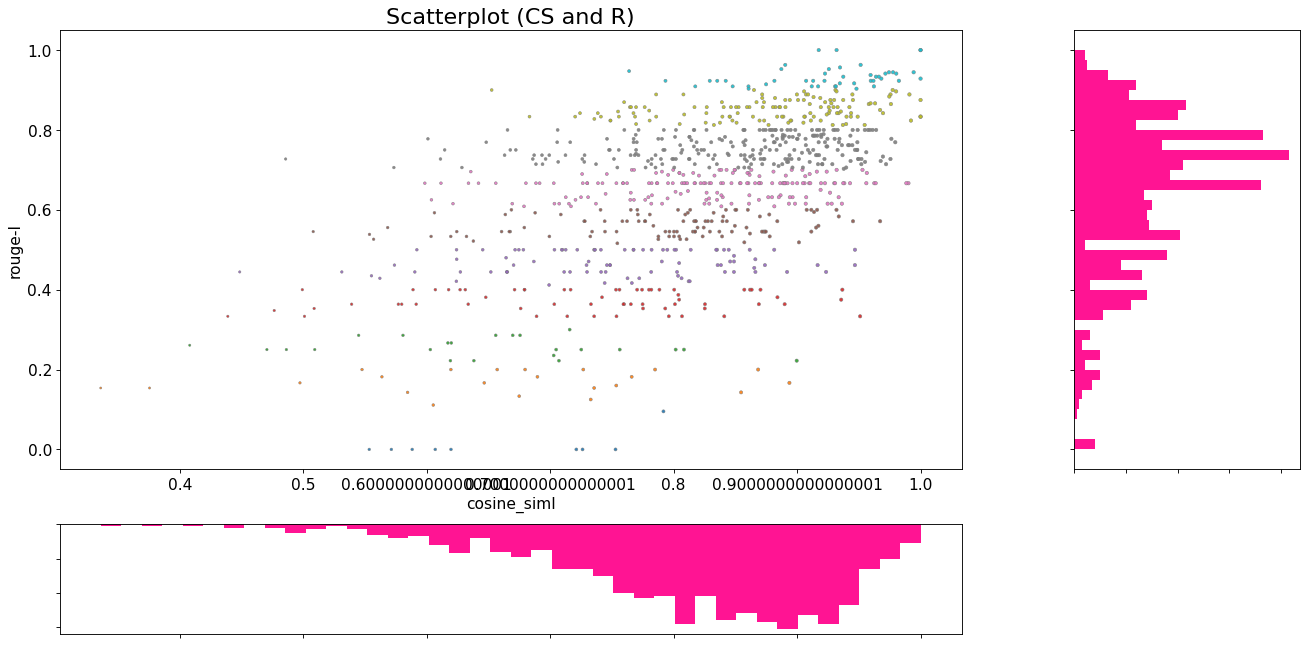

In [71]:
fig = plt.figure(figsize=(20, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('cosine_sim', 'rouge_l', s=test_df["cosine_sim"]*10, c=test_df["rouge_l"], alpha=.9, data=test_df, cmap="tab10", edgecolors='gray', linewidths=.5)

# histogram on the right
ax_bottom.hist(test_df["cosine_sim"], 40, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(test_df["rouge_l"], 40, histtype='stepfilled', orientation='horizontal', color='deeppink')

ax_main.set(title='Scatterplot (CS and R)', xlabel='cosine_siml', ylabel='rouge-l')
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
plt.show()